Paso 1: Importar las bibliotecas

In [21]:
from pytrends.request import TrendReq
import pandas as pd
from sqlalchemy import create_engine
import psycopg2


Paso 2: Conectarse a Pytrends

In [22]:
# Conectar a Pytrends
pytrends = TrendReq(hl='en-US', tz=0)


Paso 3: Definir las palabras clave y los países

In [23]:
keywords = ["Sea Level", "Weather", "Temperatures", "Carbon Dioxide", "Global Warming"]
countries = {
    'AR': 'Argentina',
    'BR': 'Brazil',
    'CL': 'Chile',
    'CO': 'Colombia',
    'MX': 'Mexico'
}

Paso 4: Obtener las tendencias para cada país

In [24]:
for code, country in countries.items():
    pytrends.build_payload(kw_list=keywords, geo=code)
    data = pytrends.interest_over_time()
    data = data.drop(columns=['isPartial'])  # Elimina la columna isPartial si existe
    data['Country'] = country  # Añade una columna para identificar el país
    # Guardar el DataFrame en un archivo CSV
    data.to_csv(f'{code}_trends.csv')


c:\Users\Alexander\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
c:\Users\Alexander\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
c:\Users\Alexander\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future ve

Paso 5: Configurar la conexión a Amazon Redshift

In [25]:
import psycopg2
from dotenv import load_dotenv
import os

# Cargar las variables del archivo .env
load_dotenv()

# Obtener las credenciales desde las variables de entorno
dbname = os.getenv('DB_NAME')
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')

try:
    connection = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )
    print("Conexión exitosa!")
    
    cursor = connection.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("Conectado a:", record)
    
    cursor.close()
    connection.close()
except Exception as e:
    print("Ocurrió un error:", e)


Conexión exitosa!
Conectado a: ('PostgreSQL 8.0.2 on i686-pc-linux-gnu, compiled by GCC gcc (GCC) 3.4.2 20041017 (Red Hat 3.4.2-6.fc3), Redshift 1.0.71629',)


In [26]:
import psycopg2
from dotenv import load_dotenv
import os

# Cargar las variables del archivo .env
load_dotenv()

# Obtener las credenciales desde las variables de entorno
dbname = 'fin_del_mundo'  # O usa 'data-engineer-database' si no puedes crear la base de datos
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')

try:
    connection = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )
    cursor = connection.cursor()
    
    # Crear tablas para cada país
    country_codes = ['AR', 'BR', 'CL', 'CO', 'MX']
    for code in country_codes:
        try:
            cursor.execute(f"""
                CREATE TABLE IF NOT EXISTS {code} (
                    date DATE,
                    Sea_Level FLOAT,
                    Weather FLOAT,
                    Temperatures FLOAT,
                    Carbon_Dioxide FLOAT,
                    Global_Warming FLOAT,
                    Country VARCHAR(255)
                );
            """)
            connection.commit()
            print(f"Tabla para {code} creada exitosamente.")
        except Exception as e:
            print(f"Ocurrió un error al crear la tabla para {code}:", e)

except Exception as e:
    print("Ocurrió un error al conectar a Redshift:", e)
finally:
    if cursor is not None:
        cursor.close()
    if connection is not None:
        connection.close()


Tabla para AR creada exitosamente.
Tabla para BR creada exitosamente.
Tabla para CL creada exitosamente.
Tabla para CO creada exitosamente.
Tabla para MX creada exitosamente.


In [31]:
import pandas as pd

# Cargar y combinar los archivos CSV
country_codes = ['AR', 'BR', 'CL', 'CO', 'MX']
combined_data = pd.concat([pd.read_csv(f'{code}_trends.csv') for code in country_codes])

# Mostrar las primeras filas del DataFrame combinado
combined_data.head()


,date,Sea Level,Weather,Temperatures,Carbon Dioxide,Global Warming,Country
0,2019-08-04,0,38,0,0,0,Argentina
1,2019-08-11,0,38,0,0,0,Argentina
2,2019-08-18,0,39,0,0,0,Argentina
3,2019-08-25,0,50,0,0,0,Argentina
4,2019-09-01,0,41,0,0,0,Argentina


In [33]:
# Crear una copia del DataFrame
df_corrected = combined_data.copy()

# Renombrar las columnas para que coincidan con los nombres en el SQL
df_corrected.columns = [
    'date',
    'sea_level',
    'weather',
    'temperatures',
    'carbon_dioxide',
    'global_warming',
    'country'
]

# Verificar los cambios
df_corrected.head()

,date,sea_level,weather,temperatures,carbon_dioxide,global_warming,country
0,2019-08-04,0,38,0,0,0,Argentina
1,2019-08-11,0,38,0,0,0,Argentina
2,2019-08-18,0,39,0,0,0,Argentina
3,2019-08-25,0,50,0,0,0,Argentina
4,2019-09-01,0,41,0,0,0,Argentina


In [35]:
dbname = 'data-engineer-database'  # Asegúrate de usar la base de datos correcta


In [37]:
import psycopg2
from dotenv import load_dotenv
import os

# Cargar las variables del archivo .env
load_dotenv()

# Obtener las credenciales desde las variables de entorno
dbname = 'data-engineer-database'
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')

try:
    # Conectar a la base de datos
    connection = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )
    cursor = connection.cursor()

    # Insertar una fila de prueba
    cursor.execute("""
        INSERT INTO trends (date, sea_level, weather, temperatures, carbon_dioxide, global_warming, country)
        VALUES ('2024-01-01', 1, 1, 1, 1, 1, 'TestCountry')
    """)
    
    connection.commit()
    print("Fila de prueba insertada exitosamente en la tabla trends.")
    
except Exception as e:
    print("Ocurrió un error al insertar datos en la tabla trends:", e)
finally:
    if cursor is not None:
        cursor.close()
    if connection is not None:
        connection.close()


Fila de prueba insertada exitosamente en la tabla trends.


In [38]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os

# Cargar las variables del archivo .env
load_dotenv()

# Obtener las credenciales desde las variables de entorno
dbname = 'data-engineer-database'
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')

try:
    # Conectar a la base de datos
    connection = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )
    cursor = connection.cursor()
    
    # Leer el DataFrame combinado con nombres de columnas corregidos
    df_corrected = pd.concat([pd.read_csv(f'{code}_trends.csv') for code in ['AR', 'BR', 'CL', 'CO', 'MX']])
    df_corrected.columns = [
        'date',
        'sea_level',
        'weather',
        'temperatures',
        'carbon_dioxide',
        'global_warming',
        'country'
    ]
    
    # Insertar datos en la tabla
    for _, row in df_corrected.iterrows():
        cursor.execute("""
            INSERT INTO trends (date, sea_level, weather, temperatures, carbon_dioxide, global_warming, country)
            VALUES (%s, %s, %s, %s, %s, %s, %s)
        """, (
            row['date'],
            row['sea_level'],
            row['weather'],
            row['temperatures'],
            row['carbon_dioxide'],
            row['global_warming'],
            row['country']
        ))
    
    connection.commit()
    print("Datos insertados exitosamente en la tabla trends.")
    
except Exception as e:
    print("Ocurrió un error al insertar datos en la tabla trends:", e)
finally:
    if cursor is not None:
        cursor.close()
    if connection is not None:
        connection.close()


Datos insertados exitosamente en la tabla trends.


In [61]:
# Estadísticas descriptivas
stats = df_corrected.describe()
print(stats)


         sea_level      weather  temperatures  carbon_dioxide  global_warming
count  1310.000000  1310.000000   1310.000000     1310.000000     1310.000000
mean      0.035878    46.519847      0.019084        0.022137        0.103817
std       0.186057    14.055847      0.136872        0.147187        0.314994
min       0.000000    22.000000      0.000000        0.000000        0.000000
25%       0.000000    36.000000      0.000000        0.000000        0.000000
50%       0.000000    44.000000      0.000000        0.000000        0.000000
75%       0.000000    54.000000      0.000000        0.000000        0.000000
max       1.000000   100.000000      1.000000        1.000000        2.000000


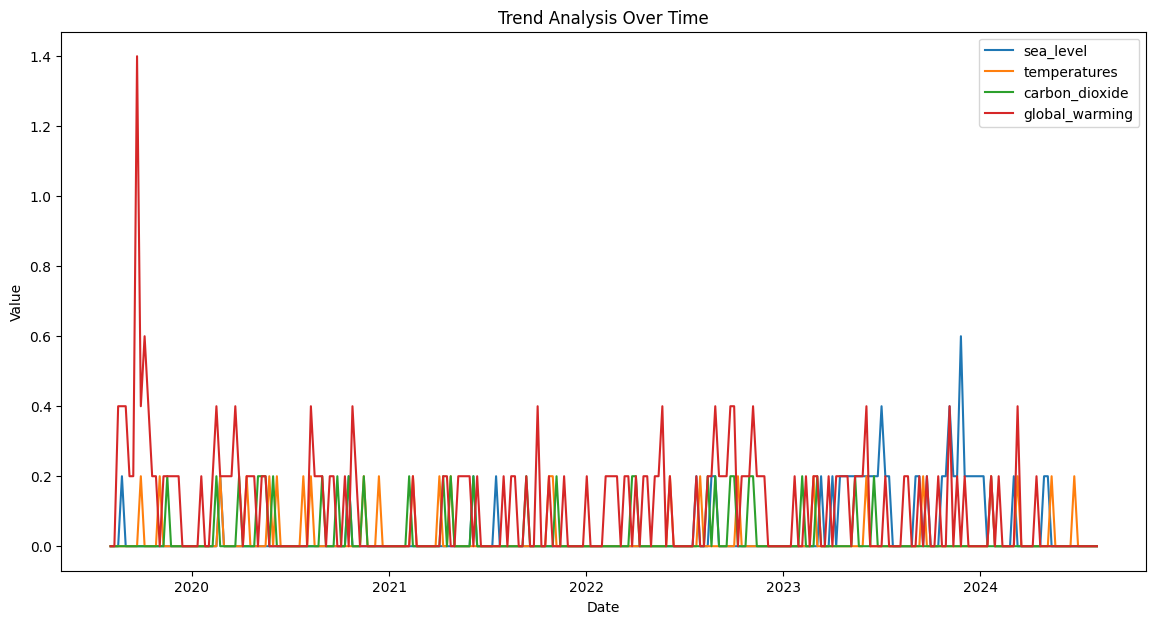

In [62]:
import matplotlib.pyplot as plt

# Convertir la columna de fecha a tipo datetime
df_corrected['date'] = pd.to_datetime(df_corrected['date'])

# Graficar tendencias
plt.figure(figsize=(14, 7))
for column in ['sea_level', 'temperatures', 'carbon_dioxide', 'global_warming']:
    plt.plot(df_corrected.groupby('date')[column].mean(), label=column)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trend Analysis Over Time')
plt.legend()
plt.show()


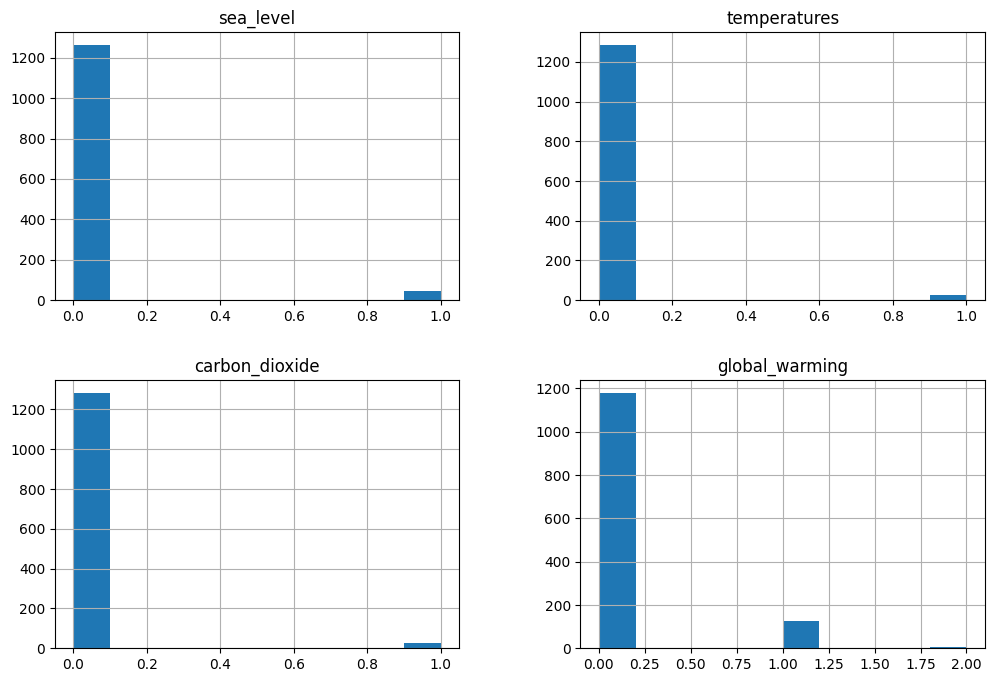

In [63]:
# Histogramas para cada variable
df_corrected[['sea_level', 'temperatures', 'carbon_dioxide', 'global_warming']].hist(bins=10, figsize=(12, 8))
plt.show()


In [64]:
# Matriz de correlación
correlation_matrix = df_corrected[['sea_level', 'temperatures', 'carbon_dioxide', 'global_warming']].corr()
print(correlation_matrix)


                sea_level  temperatures  carbon_dioxide  global_warming
sea_level        1.000000      0.003091        0.026768        0.001572
temperatures     0.003091      1.000000        0.016934        0.113483
carbon_dioxide   0.026768      0.016934        1.000000        0.181076
global_warming   0.001572      0.113483        0.181076        1.000000


c:\Users\Alexander\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


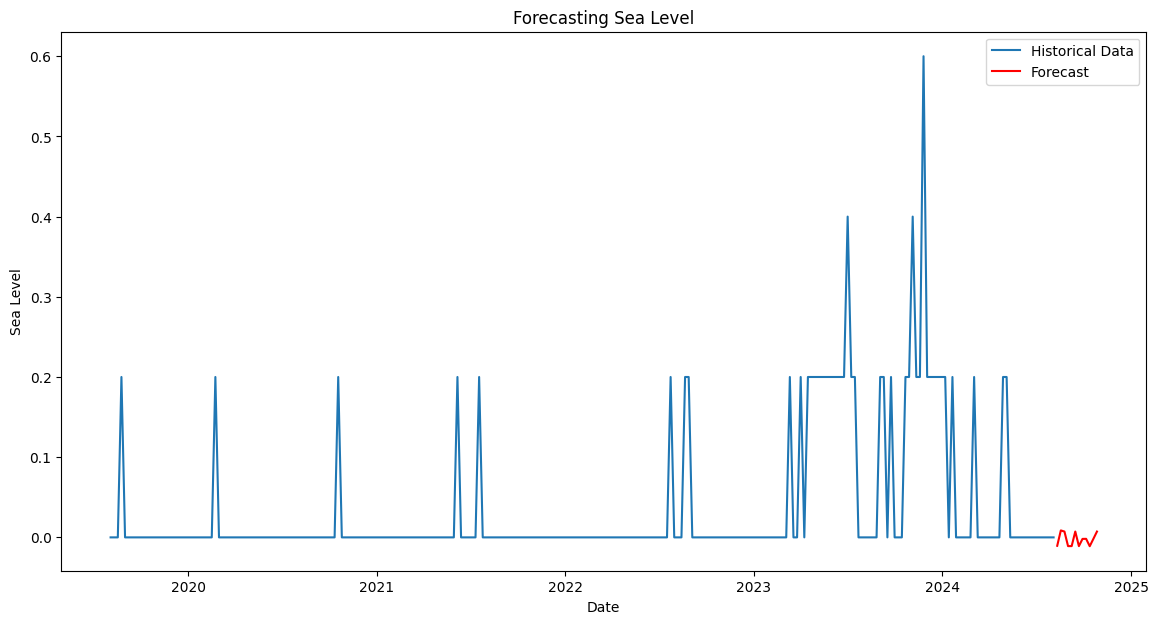

In [67]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar un modelo Holt-Winters para una variable
model = ExponentialSmoothing(df_corrected.groupby('date')['sea_level'].mean(), trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()

# Hacer predicciones
forecast = fit.forecast(steps=12)

# Graficar predicciones
plt.figure(figsize=(14, 7))
plt.plot(df_corrected.groupby('date')['sea_level'].mean(), label='Historical Data')
plt.plot(forecast.index, forecast.values, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Sea Level')
plt.title('Forecasting Sea Level')
plt.legend()
plt.show()


In [13]:
from statsmodels.tsa.stattools import adfuller

# Prueba ADF
result_adf = adfuller(grouped_data)
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])


ADF Statistic: -4.460725
p-value: 0.000231


<Figure size 1400x800 with 0 Axes>

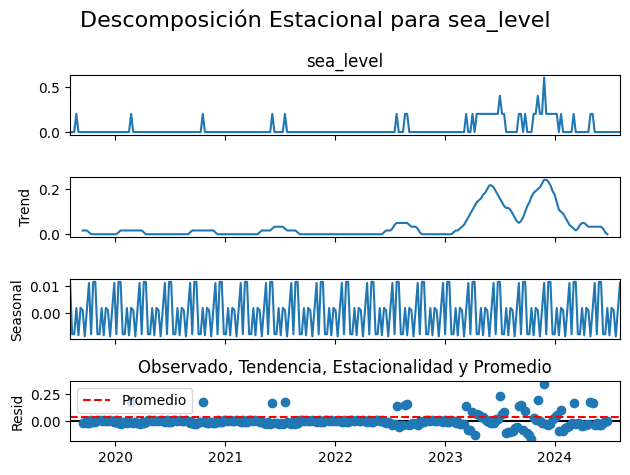

Prueba ADF para sea_level:
ADF Statistic: -3.037679
p-value: 0.031522
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


<Figure size 1400x800 with 0 Axes>

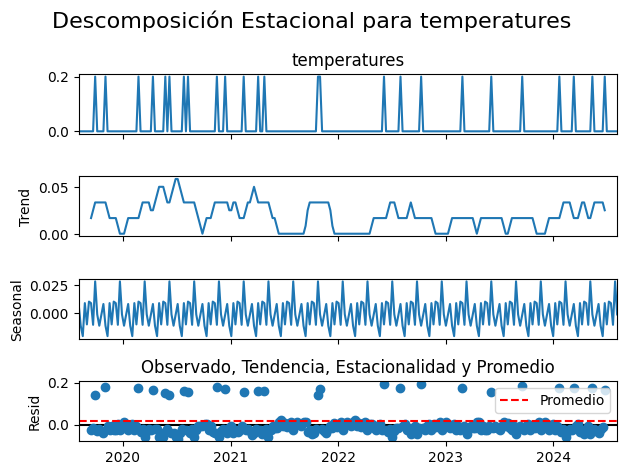

Prueba ADF para temperatures:
ADF Statistic: -17.118973
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


<Figure size 1400x800 with 0 Axes>

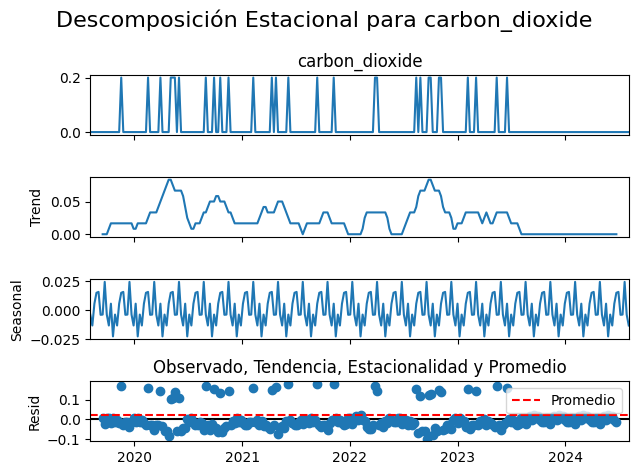

Prueba ADF para carbon_dioxide:
ADF Statistic: -15.019342
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


<Figure size 1400x800 with 0 Axes>

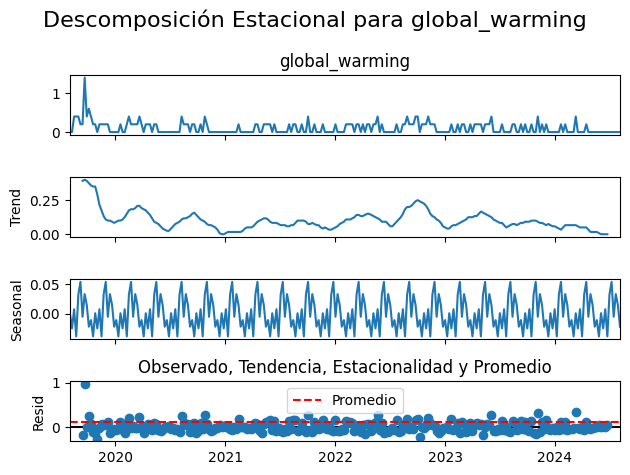

Prueba ADF para global_warming:
ADF Statistic: -4.460725
p-value: 0.000231
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# ... (cargar datos)

# Descomposición estacional con personalización
for column in columns_to_analyze:
    plt.figure(figsize=(14, 8))
    grouped_data = df_corrected.groupby('date')[column].mean()
    result = seasonal_decompose(grouped_data, model='add', period=12)
    result.plot()

    # Añadir línea de promedio y título
    plt.axhline(y=grouped_data.mean(), color='r', linestyle='--', label='Promedio')
    plt.suptitle(f'Descomposición Estacional para {column}', fontsize=16)
    plt.title('Observado, Tendencia, Estacionalidad y Promedio', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Prueba ADF
    result_adf = adfuller(grouped_data)
    print(f"Prueba ADF para {column}:")
    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')
    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))


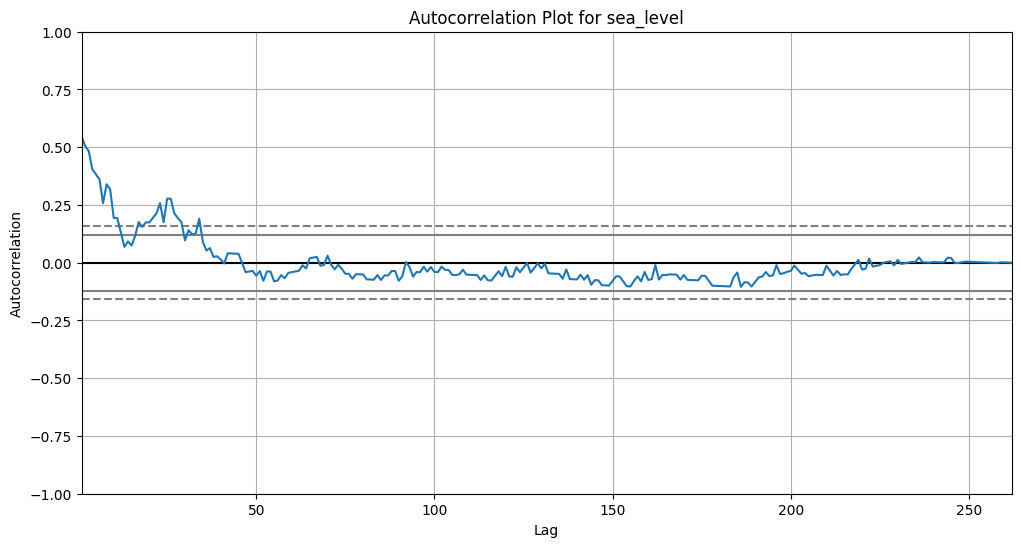

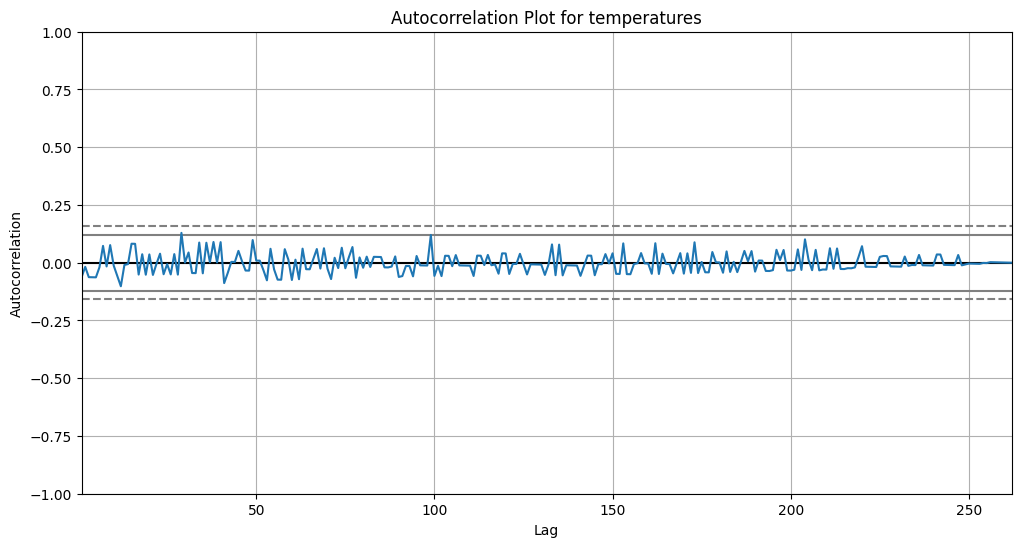

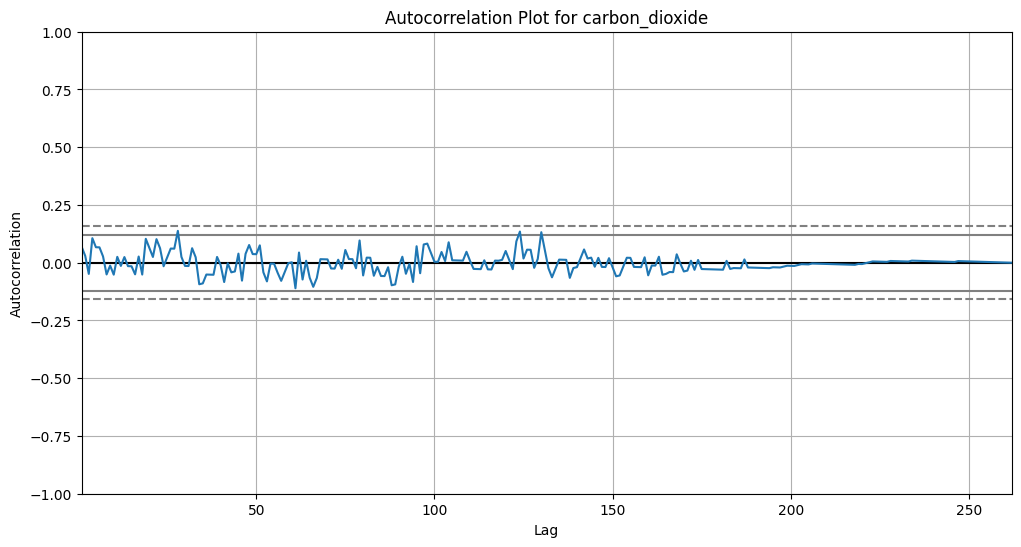

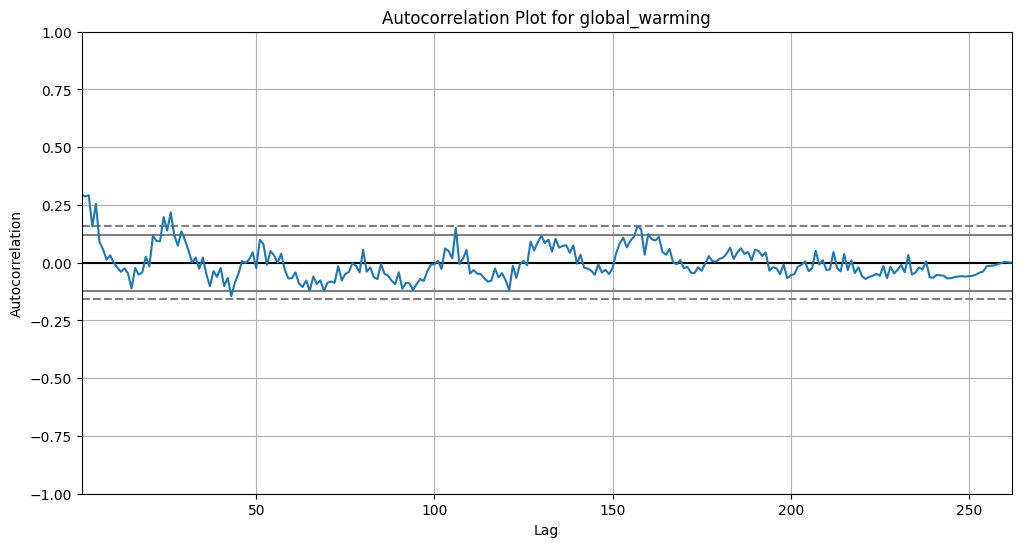

In [16]:
from pandas.plotting import autocorrelation_plot

# Para cada columna
for column in columns_to_analyze:
    plt.figure(figsize=(12, 6))
    autocorrelation_plot(df_corrected.groupby('date')[column].mean())
    plt.title(f'Autocorrelation Plot for {column}')
    plt.show()


In [17]:
from statsmodels.tsa.stattools import adfuller

# Para cada columna
for column in columns_to_analyze:
    result = adfuller(df_corrected.groupby('date')[column].mean().dropna())
    print(f'{column} - ADF Statistic: {result[0]}')
    print(f'{column} - p-value: {result[1]}')


sea_level - ADF Statistic: -3.0376785655942835
sea_level - p-value: 0.03152239427619009
temperatures - ADF Statistic: -17.11897334990954
temperatures - p-value: 7.278591068127645e-30
carbon_dioxide - ADF Statistic: -15.019342367803269
carbon_dioxide - p-value: 1.0277982042710339e-27
global_warming - ADF Statistic: -4.460725480054552
global_warming - p-value: 0.00023139446241088988



Análisis ARIMA para sea_level:


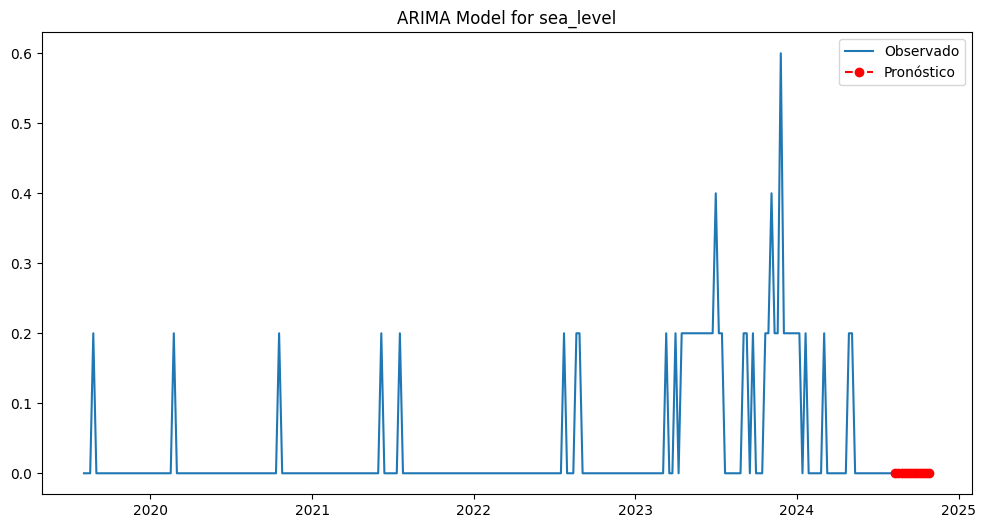

                               SARIMAX Results                                
Dep. Variable:              sea_level   No. Observations:                  262
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 327.958
Date:                Sat, 10 Aug 2024   AIC                           -643.916
Time:                        18:05:00   BIC                           -622.528
Sample:                    08-04-2019   HQIC                          -635.319
                         - 08-04-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6382      0.043    -14.840      0.000      -0.723      -0.554
ar.L2         -0.4071      0.055     -7.467      0.000      -0.514      -0.300
ar.L3         -0.2159      0.061     -3.565      0.0

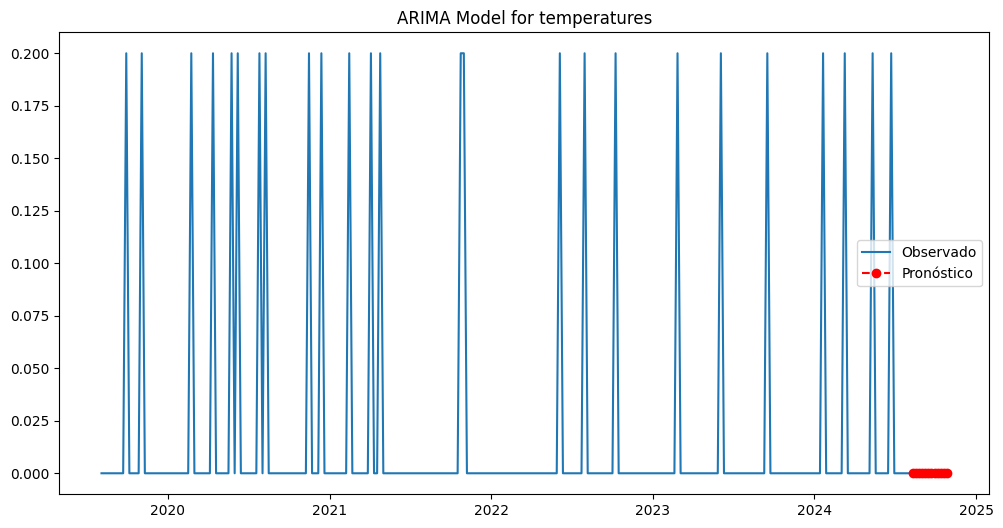

                               SARIMAX Results                                
Dep. Variable:           temperatures   No. Observations:                  262
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 342.925
Date:                Sat, 10 Aug 2024   AIC                           -673.850
Time:                        18:05:00   BIC                           -652.463
Sample:                    08-04-2019   HQIC                          -665.253
                         - 08-04-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8412      0.073    -11.486      0.000      -0.985      -0.698
ar.L2         -0.6421      0.087     -7.353      0.000      -0.813      -0.471
ar.L3         -0.4926      0.093     -5.283      0.0

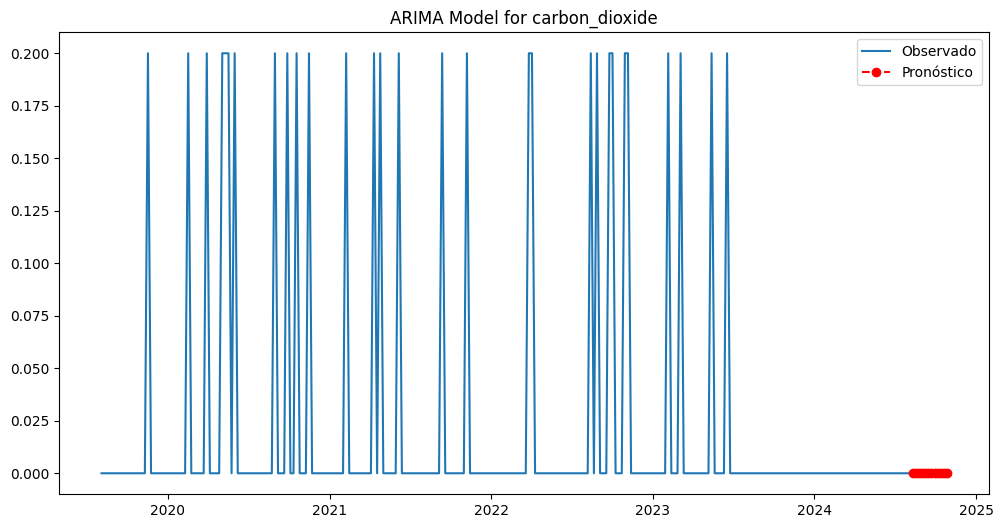

                               SARIMAX Results                                
Dep. Variable:         carbon_dioxide   No. Observations:                  262
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 340.373
Date:                Sat, 10 Aug 2024   AIC                           -668.746
Time:                        18:05:01   BIC                           -647.359
Sample:                    08-04-2019   HQIC                          -660.149
                         - 08-04-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8086      0.054    -14.998      0.000      -0.914      -0.703
ar.L2         -0.6614      0.065    -10.120      0.000      -0.790      -0.533
ar.L3         -0.5855      0.066     -8.858      0.0

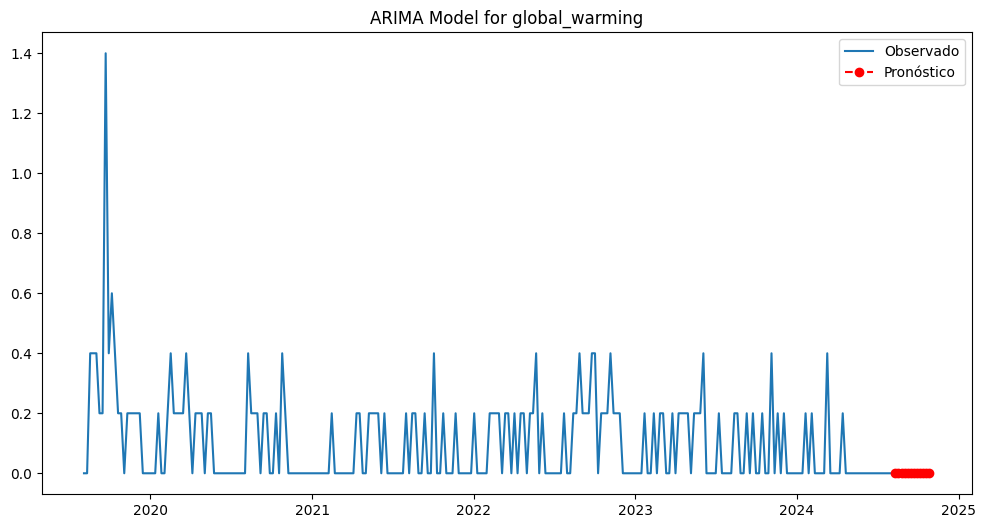

                               SARIMAX Results                                
Dep. Variable:         global_warming   No. Observations:                  262
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 139.096
Date:                Sat, 10 Aug 2024   AIC                           -266.192
Time:                        18:05:01   BIC                           -244.804
Sample:                    08-04-2019   HQIC                          -257.595
                         - 08-04-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7263      0.059    -12.396      0.000      -0.841      -0.611
ar.L2         -0.5142      0.073     -6.997      0.000      -0.658      -0.370
ar.L3         -0.2823      0.075     -3.742      0.0

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Asegúrate de que df_corrected ya tiene la columna 'date' como índice
# Si no es así, puedes usar la siguiente línea para establecer el índice:
# df_corrected.set_index('date', inplace=True)

# Función para ajustar el modelo ARIMA y hacer predicciones
def fit_arima_and_plot(series, title):
    plt.figure(figsize=(12, 6))
    
    # Ajustar el modelo ARIMA
    model = ARIMA(series, order=(5,1,0))  # Ajusta los parámetros (p,d,q) según sea necesario
    model_fit = model.fit()
    
    # Hacer predicciones
    forecast = model_fit.forecast(steps=12)  # Predecir 12 pasos adelante
    forecast_index = pd.date_range(start=series.index[-1] + pd.DateOffset(days=7), periods=12, freq='W')
    
    # Visualizar la serie temporal y las predicciones
    plt.plot(series, label='Observado')
    plt.plot(forecast_index, forecast, color='red', linestyle='--', marker='o', label='Pronóstico')
    plt.title(title)
    plt.legend()
    plt.show()
    
    # Mostrar resumen del modelo
    print(model_fit.summary())

# Ajustar y visualizar ARIMA para cada columna
for column in ['sea_level', 'temperatures', 'carbon_dioxide', 'global_warming']:
    print(f"\nAnálisis ARIMA para {column}:")
    series = df_corrected[column].resample('W').mean()
    fit_arima_and_plot(series, f'ARIMA Model for {column}')


In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt


c:\Users\Alexander\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


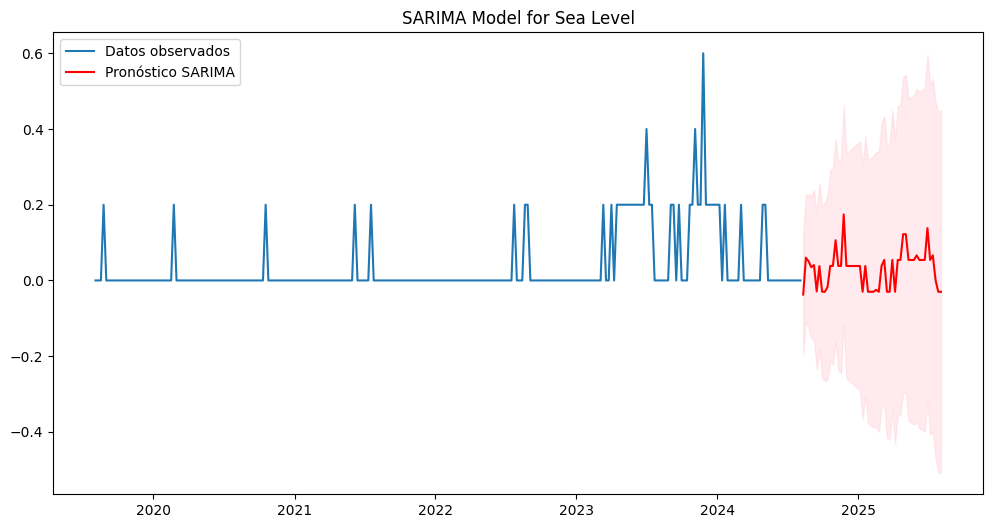

c:\Users\Alexander\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


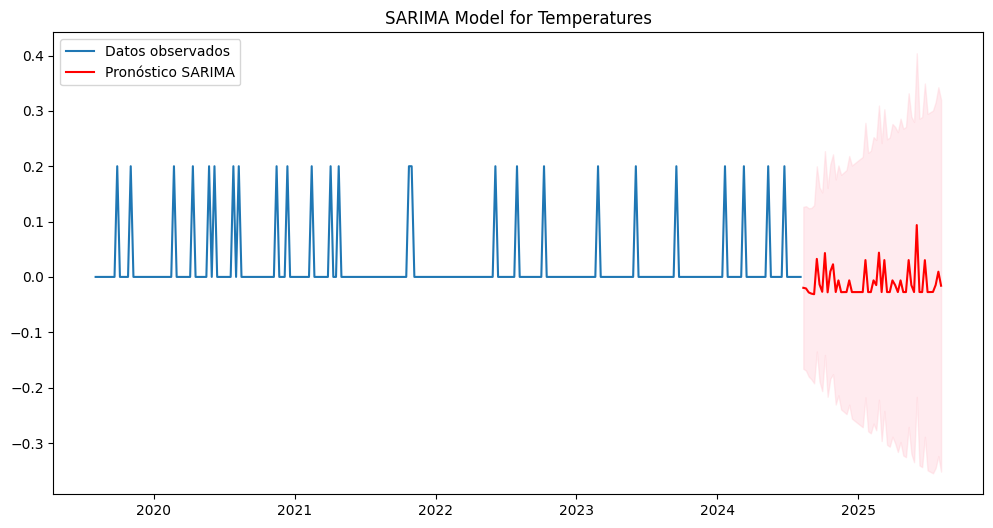

c:\Users\Alexander\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


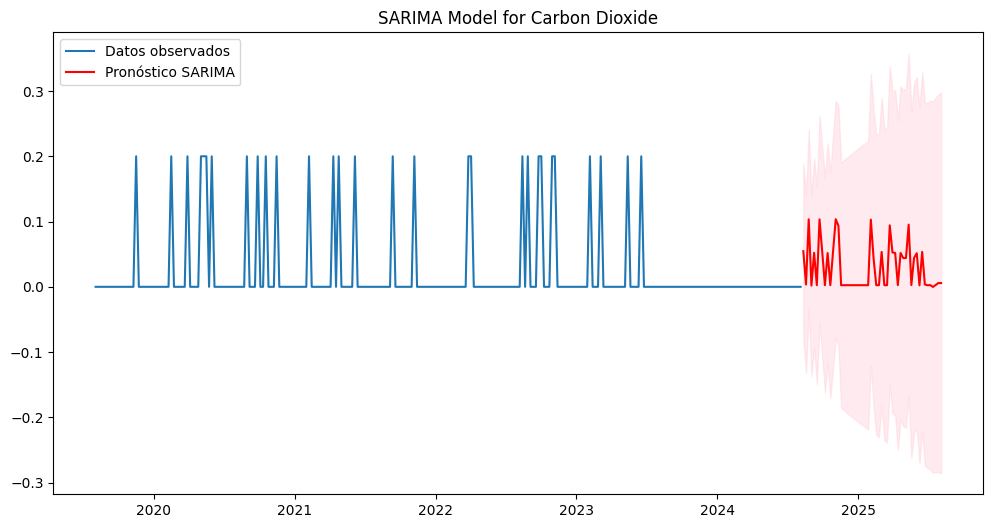

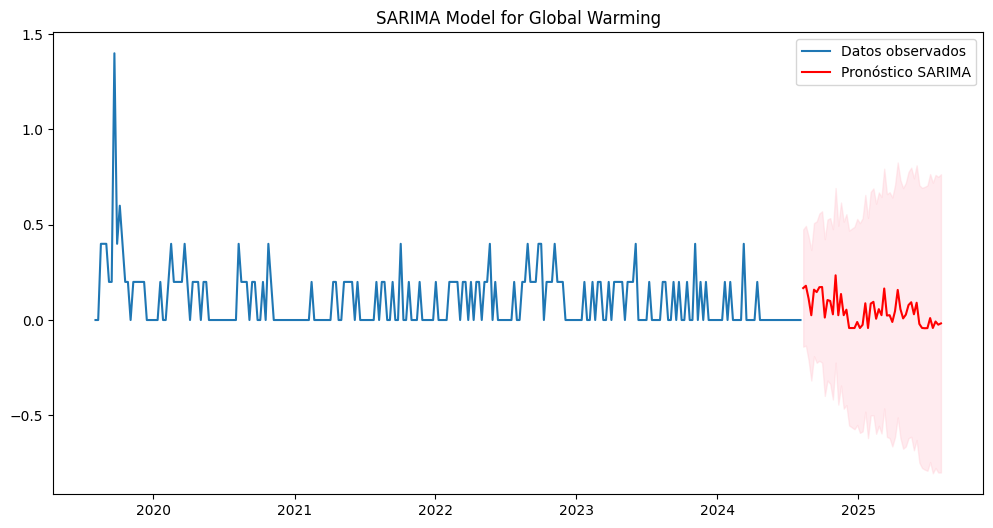

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

def fit_sarima_and_plot(series, title, seasonal_periods):
    # Ajustar el modelo SARIMA
    model = SARIMAX(series,
                    order=(5, 1, 0),         # Parámetros ARIMA
                    seasonal_order=(1, 1, 1, seasonal_periods))  # Parámetros estacionales
    model_fit = model.fit(disp=False)

    # Hacer predicciones
    forecast = model_fit.get_forecast(steps=52)  # Predecir 52 pasos adelante
    forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(weeks=1), periods=52, freq='W')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    conf_int = forecast.conf_int()

    # Graficar resultados
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Datos observados')
    plt.plot(forecast_series, label='Pronóstico SARIMA', color='red')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(title)
    plt.legend()
    plt.show()

# Aplicar SARIMA para cada variable
seasonal_periods = 52  # Por ejemplo, si los datos son semanales y quieres capturar la estacionalidad anual

# Para `sea_level`
series_sea_level = df_corrected['sea_level'].resample('W').mean()
fit_sarima_and_plot(series_sea_level, 'SARIMA Model for Sea Level', seasonal_periods)

# Para `temperatures`
series_temperatures = df_corrected['temperatures'].resample('W').mean()
fit_sarima_and_plot(series_temperatures, 'SARIMA Model for Temperatures', seasonal_periods)

# Para `carbon_dioxide`
series_carbon_dioxide = df_corrected['carbon_dioxide'].resample('W').mean()
fit_sarima_and_plot(series_carbon_dioxide, 'SARIMA Model for Carbon Dioxide', seasonal_periods)

# Para `global_warming`
series_global_warming = df_corrected['global_warming'].resample('W').mean()
fit_sarima_and_plot(series_global_warming, 'SARIMA Model for Global Warming', seasonal_periods)
